In [165]:
import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
import model
import simulation
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import scienceplots

In [166]:
def init_run(N):
    
    voltages                    = np.random.uniform(low=-0.3, high=0.3, size=(16,5))        
    topology_parameter          = {}
    topology_parameter["Np"]    = N
    topology_parameter["Nj"]    = 4
    topology_parameter["e_pos"] = [[-1.5,-1.5],[1.5,-1.5],[-1.5,1.5],[1.5,1.5]]
    sim_class                   = simulation.simulation(voltages)
    sim_class.init_random("",topology_parameter)

    

    sim_class.net_electrostatic.init_charge_vector(voltage_values=voltages[0])

    inv_capacitance_matrix  = sim_class.net_electrostatic.return_inv_capacitance_matrix()
    charge_vector           = sim_class.net_electrostatic.return_charge_vector()

    # Model
    net_model = model.model_class(net_topology=sim_class.net_topology, inv_capacitance_matrix=inv_capacitance_matrix)
    net_model.init_potential_vector(voltage_values=voltages[0])
    net_model.init_const_capacitance_values()

    # Return Model Arguments
    potential_vector                                                                        = net_model.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = net_model.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = net_model.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = net_model.return_advanced_indices()
    temperatures, temperatures_co                                                           = net_model.return_const_temperatures(T=0.28)
    resistances, resistances_co1, resistances_co2                                           = net_model.return_const_resistances()

    # Simulation Class
    summary = simulation.simulation_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles)
    
    return summary

In [167]:
results = pd.DataFrame()
Ns      = np.arange(5,1001)
Nss     = []
times1  = []
times1s = []
times2  = []
times2s = []
times3  = []
times3s = []

for N in Ns:

    tt1 = []
    tt2 = []
    tt3 = []

    summary = init_run(N)
    summary.calc_potentials()
    
    for i in range(200000):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        if i > 100000:
            t1 = time.process_time_ns()

        summary.calc_tunnel_rates()
        # summary.calc_tunnel_rates_zero_T()
        if i > 100000:

            t2 = time.process_time_ns()

        summary.select_event(random_number1, random_number2)

        if i > 100000:
        
            t3 = time.process_time_ns()

            tt1.append(t2-t1)
            tt2.append(t3-t2)
            tt3.append(t3-t1)

    Nss.append(len(summary.tunnel_rates))
    times1.append(np.mean(tt1))
    times1s.append(np.std(tt1))

    times2.append(np.mean(tt2))
    times2s.append(np.std(tt2))

    times3.append(np.mean(tt3))
    times3s.append(np.std(tt3))

results['N']    = Nss
results['t1']   = times1
results['t1s']  = times1s
results['t2']   = times2
results['t2s']  = times2s
results['t3']   = times3
results['t3s']  = times3s

In [214]:
results[results['t1s']/results['t1'] > 0.05]

,N,t1,t1s,t2,t2s,t3,t3s
0,28,1413.056461,158.088749,1094.188182,112.467238,2507.244642,208.654300
1,32,1496.300043,149.685030,1106.943989,69.943580,2603.244032,170.495991
2,36,1591.813248,192.681586,1125.700707,158.594868,2717.513955,289.572043
3,40,1612.217152,118.439856,1107.844158,55.066928,2720.061311,135.073877
4,44,1722.359084,149.341417,1129.096851,82.701058,2851.455935,173.904255
...,...,...,...,...,...,...,...
605,2448,21032.912339,1211.631704,3877.143901,797.021274,24910.056241,1610.628564
640,2588,26335.650717,2709.799138,3926.155522,1658.032456,30261.806238,3384.218686
876,3532,33833.736467,1778.620254,5145.143281,1334.114320,38978.879749,2494.110271
924,3724,36079.977260,2030.531711,5465.321453,1221.813584,41545.298713,2523.169539


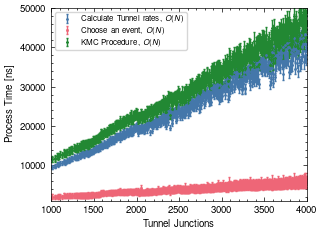

In [256]:
df = results[results['t1s']/results['t1'] < 0.05].copy().reset_index(drop=True)

with plt.style.context(["science","nature","bright"]):

    fig = plt.figure()
    ax  = fig.add_subplot()

    ax.errorbar(x=df['N'],y=df['t1'], yerr=df['t1s'], marker='o', ls='', label='Calculate Tunnel rates, $O(N)$',ms=1,capsize=1)
    ax.errorbar(x=df['N'],y=df['t2'], yerr=df['t2s'], marker='s', ls='', label='Choose an event, $O(N)$',ms=1,capsize=1)
    ax.errorbar(x=df['N'],y=df['t3'], yerr=df['t3s'], marker='X', ls='', label='KMC Procedure, $O(N)$',ms=1,capsize=1)
    ax.set_xlabel('Tunnel Junctions')
    ax.set_ylabel('Process Time [ns]')
    ax.legend(loc='upper left', fontsize='small',frameon=True)
    ax.set_ylim(1000,50000)
    ax.set_xlim(1000,4000)
    # ax.set_xscale('log')
    fig.savefig("complexity.pdf", bbox_inches='tight')
    fig.savefig("complexity.svg", bbox_inches='tight',transparent=True)
    plt.show()


In [254]:
time_ = 't2'
print(np.var(np.log(results[time_]/results['N'])))
print(np.var(np.log(results[time_]/(results['N']*np.log(results['N'])))))
print(np.var(np.log(results[time_]/np.log(results['N']))))
# print(np.var(np.log(results[time_]/np.sqrt(results['N']))))

0.24947364653035567
0.4081059568053088
0.11795852211407651


In [245]:
times   = []
Ns      = np.arange(10000,10*10000)
for N in Ns:

    x   = np.random.uniform(-1,1,N)
    y   = np.random.uniform(-1,1,N)

    t1  = time.process_time_ns()
    z   = x+y
    t2  = time.process_time_ns()

    times.append(t2-t1)

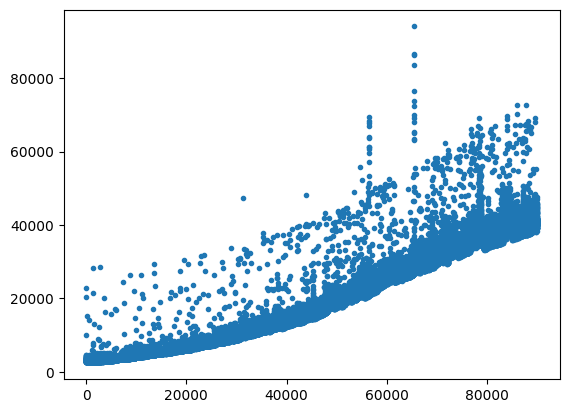

In [246]:
plt.plot(times, '.')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [257]:
import networkx as nx

In [282]:
N_particles    = 50
N_junctions    = 4
not_connected       = True

# Generate random graphs until a graph is connected
while not_connected:

    G          = nx.random_regular_graph(N_junctions, N_particles)
    not_connected   = not(nx.is_connected(G))

G   = G.to_directed()
pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, pos=pos)

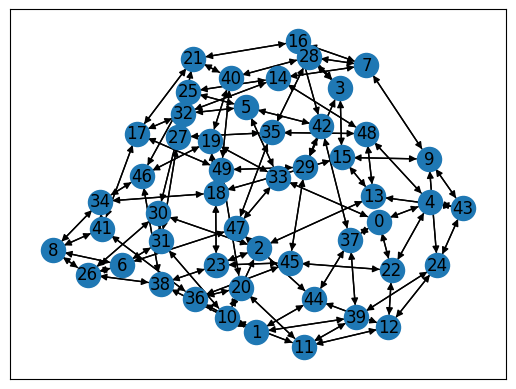

In [283]:
nx.draw_networkx(G, pos)
plt.show()

In [293]:
G = nx.grid_graph(dim=(5,5,1))
G.nodes

NodeView(((0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4)))

In [301]:
G_new = nx.convert_node_labels_to_integers(G)
G_new = G_new.to_directed()

In [303]:
G_new.edges

OutEdgeView([(0, 5), (0, 1), (1, 0), (1, 6), (1, 2), (2, 1), (2, 7), (2, 3), (3, 2), (3, 8), (3, 4), (4, 3), (4, 9), (5, 0), (5, 10), (5, 6), (6, 1), (6, 5), (6, 11), (6, 7), (7, 2), (7, 6), (7, 12), (7, 8), (8, 3), (8, 7), (8, 13), (8, 9), (9, 4), (9, 8), (9, 14), (10, 5), (10, 15), (10, 11), (11, 6), (11, 10), (11, 16), (11, 12), (12, 7), (12, 11), (12, 17), (12, 13), (13, 8), (13, 12), (13, 18), (13, 14), (14, 9), (14, 13), (14, 19), (15, 10), (15, 20), (15, 16), (16, 11), (16, 15), (16, 21), (16, 17), (17, 12), (17, 16), (17, 22), (17, 18), (18, 13), (18, 17), (18, 23), (18, 19), (19, 14), (19, 18), (19, 24), (20, 15), (20, 21), (21, 16), (21, 20), (21, 22), (22, 17), (22, 21), (22, 23), (23, 18), (23, 22), (23, 24), (24, 19), (24, 23)])

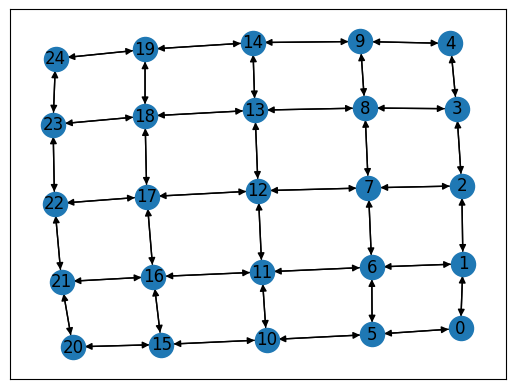

In [302]:
nx.draw_networkx(G_new)
plt.show()